# MUMA Lab 2
Autor: Marcin Poloczek 

# Problem Description

Dataset characteristics

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

- Regression: 
	Predication of bike rental count hourly or daily based on the environmental and seasonal settings.

- Event and Anomaly Detection:  
	Count of rented bikes are also correlated to some events in the town which easily are traceable via search engines.
	For instance, query like "2012-10-30 washington d.c." in Google returns related results to Hurricane Sandy. Some of the important events are 
	identified in [1]. Therefore the data can be used for validation of anomaly or event detection algorithms as well.

# Data : day.csv

# Get the data

In [329]:
library(BCA);
library(car);
library(RcmdrMisc);
library(sandwich);
library(relimp);
library(corrplot);
library(tidyverse);
library(tidyr);
library(gridExtra);

options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 150)

bikes_day <- read_csv("data/day.csv",
    col_types = "fDfffffffdddddiii")

head(bikes_day)

instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<fct>,<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


In [330]:
bikes_day %>%
    summary()

    instant        dteday           season  yr           mnth     holiday
 1      :  1   Min.   :2011-01-01   1:181   0:365   1      : 62   0:710  
 2      :  1   1st Qu.:2011-07-02   2:184   1:366   3      : 62   1: 21  
 3      :  1   Median :2012-01-01   3:188           5      : 62          
 4      :  1   Mean   :2012-01-01   4:178           7      : 62          
 5      :  1   3rd Qu.:2012-07-01                   8      : 62          
 6      :  1   Max.   :2012-12-31                   10     : 62          
 (Other):725                                        (Other):359          
 weekday workingday weathersit      temp             atemp        
 6:105   0:231      2:247      Min.   :0.05913   Min.   :0.07907  
 0:105   1:500      1:463      1st Qu.:0.33708   1st Qu.:0.33784  
 1:105              3: 21      Median :0.49833   Median :0.48673  
 2:104                         Mean   :0.49538   Mean   :0.47435  
 3:104                         3rd Qu.:0.65542   3rd Qu.:0.60860  
 4:104

# Inspect the Data

## Instant
Remove the `ID` column.

In [331]:
bikes_day <- bikes_day %>%
    select(-instant)

## Holiday
The `holiday` variable is heavily underrepresented. There are 710 false values and 21 true values. Let's inspect it.

In [332]:
bikes_day %>%
    select(holiday) %>%
    summary()

 holiday
 0:710  
 1: 21  

Let's see what are the average counts on these days.

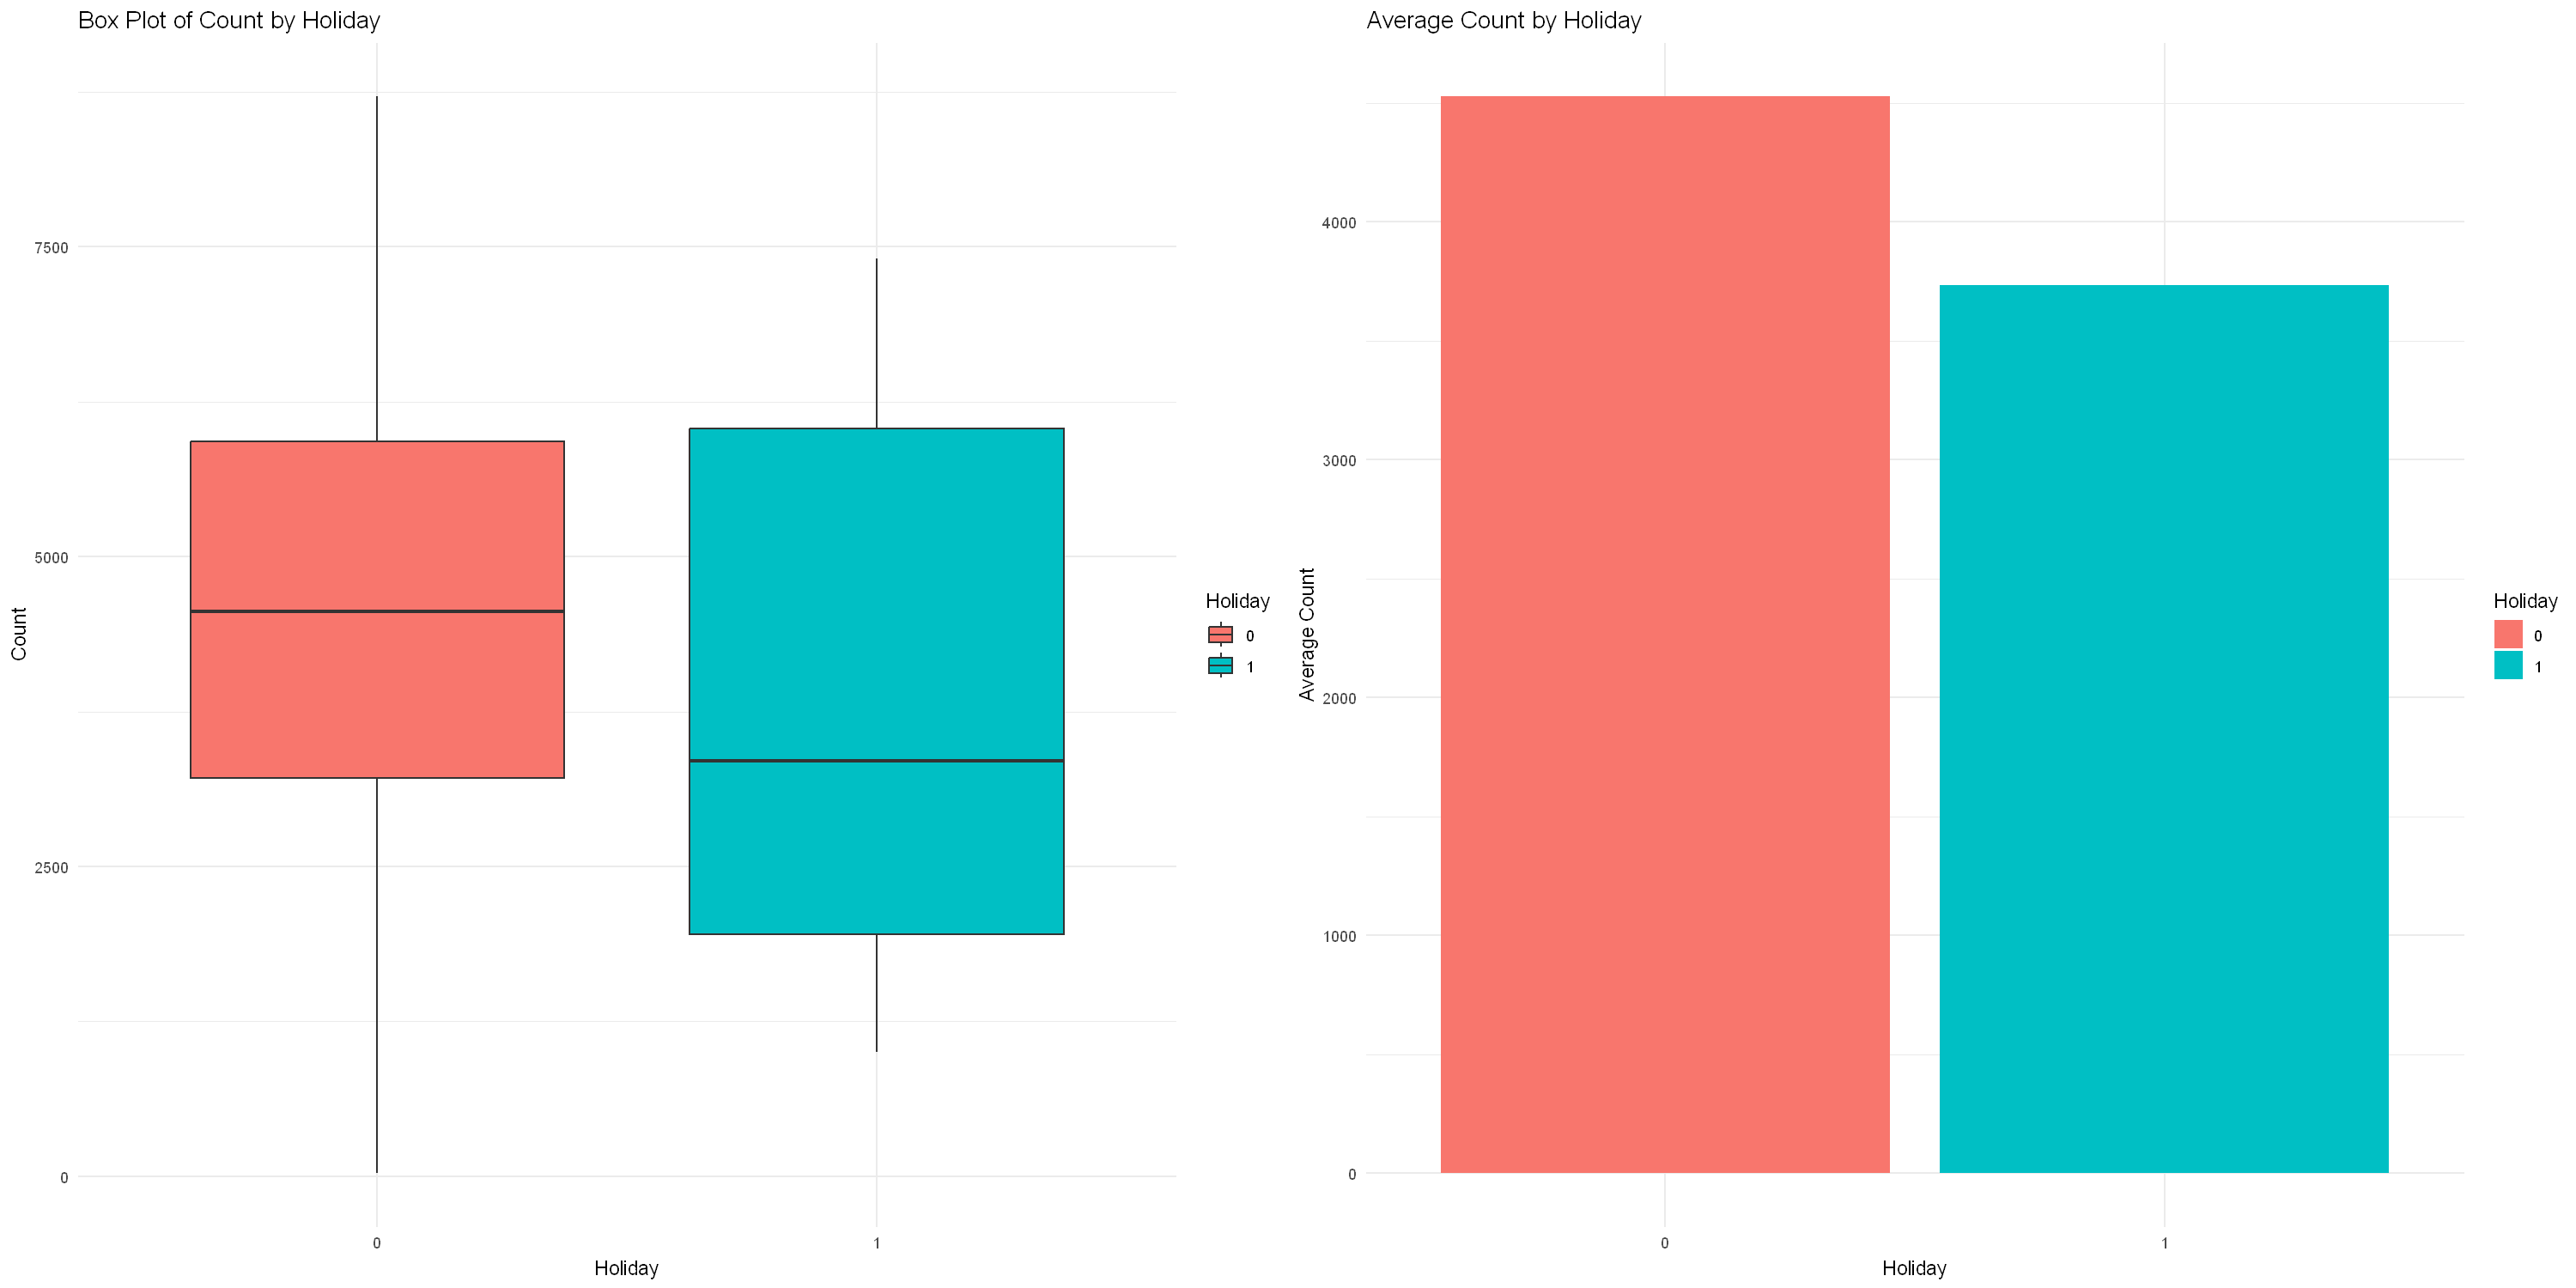

In [333]:
p0 <- bikes_day %>% 
    ggplot(aes(x = holiday, y = cnt, fill = holiday)) +
    geom_boxplot() +
    labs(title = "Box Plot of Count by Holiday",
        x = "Holiday",
        y = "Count",
        fill = "Holiday") +
    theme_minimal()

average_count <- aggregate(cnt ~ holiday, data = bikes_day, FUN = mean)

p1 <- ggplot(average_count, aes(x = holiday, y = cnt, fill = holiday)) +
    geom_bar(stat = "identity") +
    labs(title = "Average Count by Holiday",
        x = "Holiday",
        y = "Average Count",
        fill = "Holiday") +
    theme_minimal()

grid.arrange(p0, p1, ncol=2, nrow = 1)

There is no visible correlation between holidays and the number of rentals. We can remove this variable.

In [334]:
bikes_day <- bikes_day %>%
    select(-holiday)

## Correlation Matrix

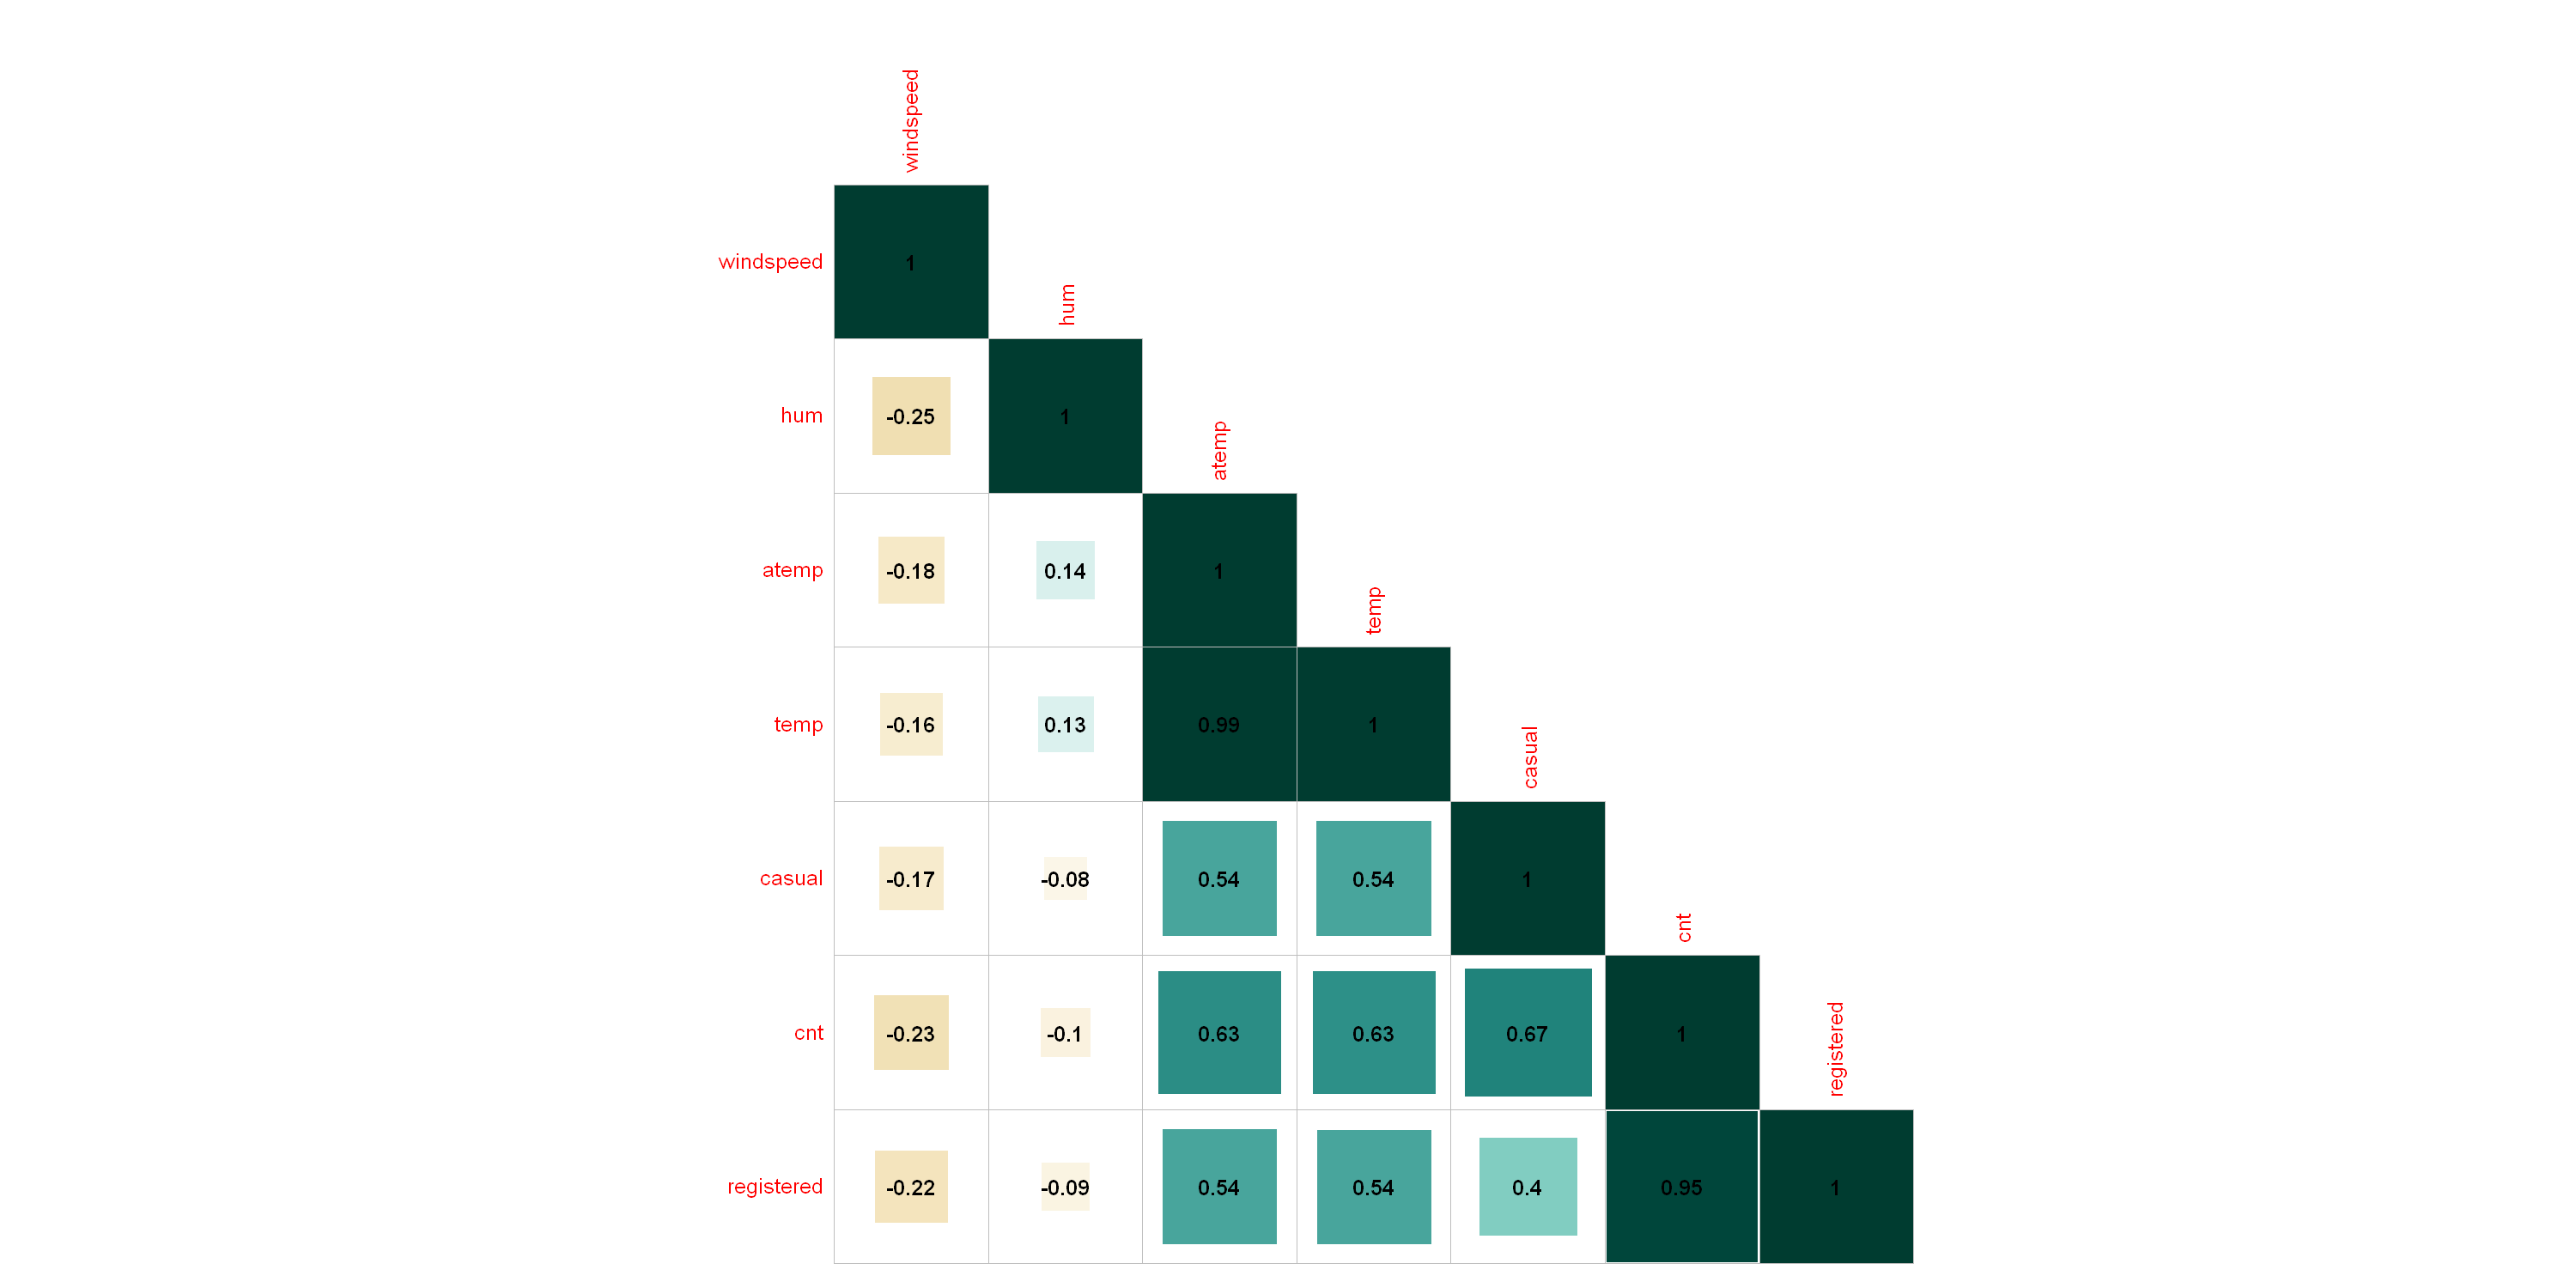

In [335]:
bikes_day %>%
    select_if(~is.numeric(.) || is.logical(.)) %>%
    cor(use = "complete.obs") %>%
    corrplot(method = "square", order = "AOE", addCoef.col = "black", tl.pos = "ld",  cl.pos = "n", col = COL2("BrBG"), type = "lower")

`cnt` is highly correlated with parameters `attempt`, `temp`, `casual`, and `registered`.

In [336]:
bikes_day %>%
    mutate(cnt_sum = (casual + registered == cnt)) %>%
    select(cnt_sum) %>%
    summary()

 cnt_sum       
 Mode:logical  
 TRUE:731      

I've created a new boolean variable by testing the equation `casual + registered == cnt`. All the values are true we can conclude that `cnt` has been generated from `casual` and `registered`. We can remove these variables.

In [337]:
bikes_day <- bikes_day %>%
    select(-casual, -registered)

head(bikes_day)

dteday,season,yr,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2011-01-01,1,0,1,6,0,2,0.344167,0.363625,0.805833,0.1604460,985
2011-01-02,1,0,1,0,0,2,0.363478,0.353739,0.696087,0.2485390,801
2011-01-03,1,0,1,1,1,1,0.196364,0.189405,0.437273,0.2483090,1349
2011-01-04,1,0,1,2,1,1,0.200000,0.212122,0.590435,0.1602960,1562
2011-01-05,1,0,1,3,1,1,0.226957,0.229270,0.436957,0.1869000,1600
2011-01-06,1,0,1,4,1,1,0.204348,0.233209,0.518261,0.0895652,1606


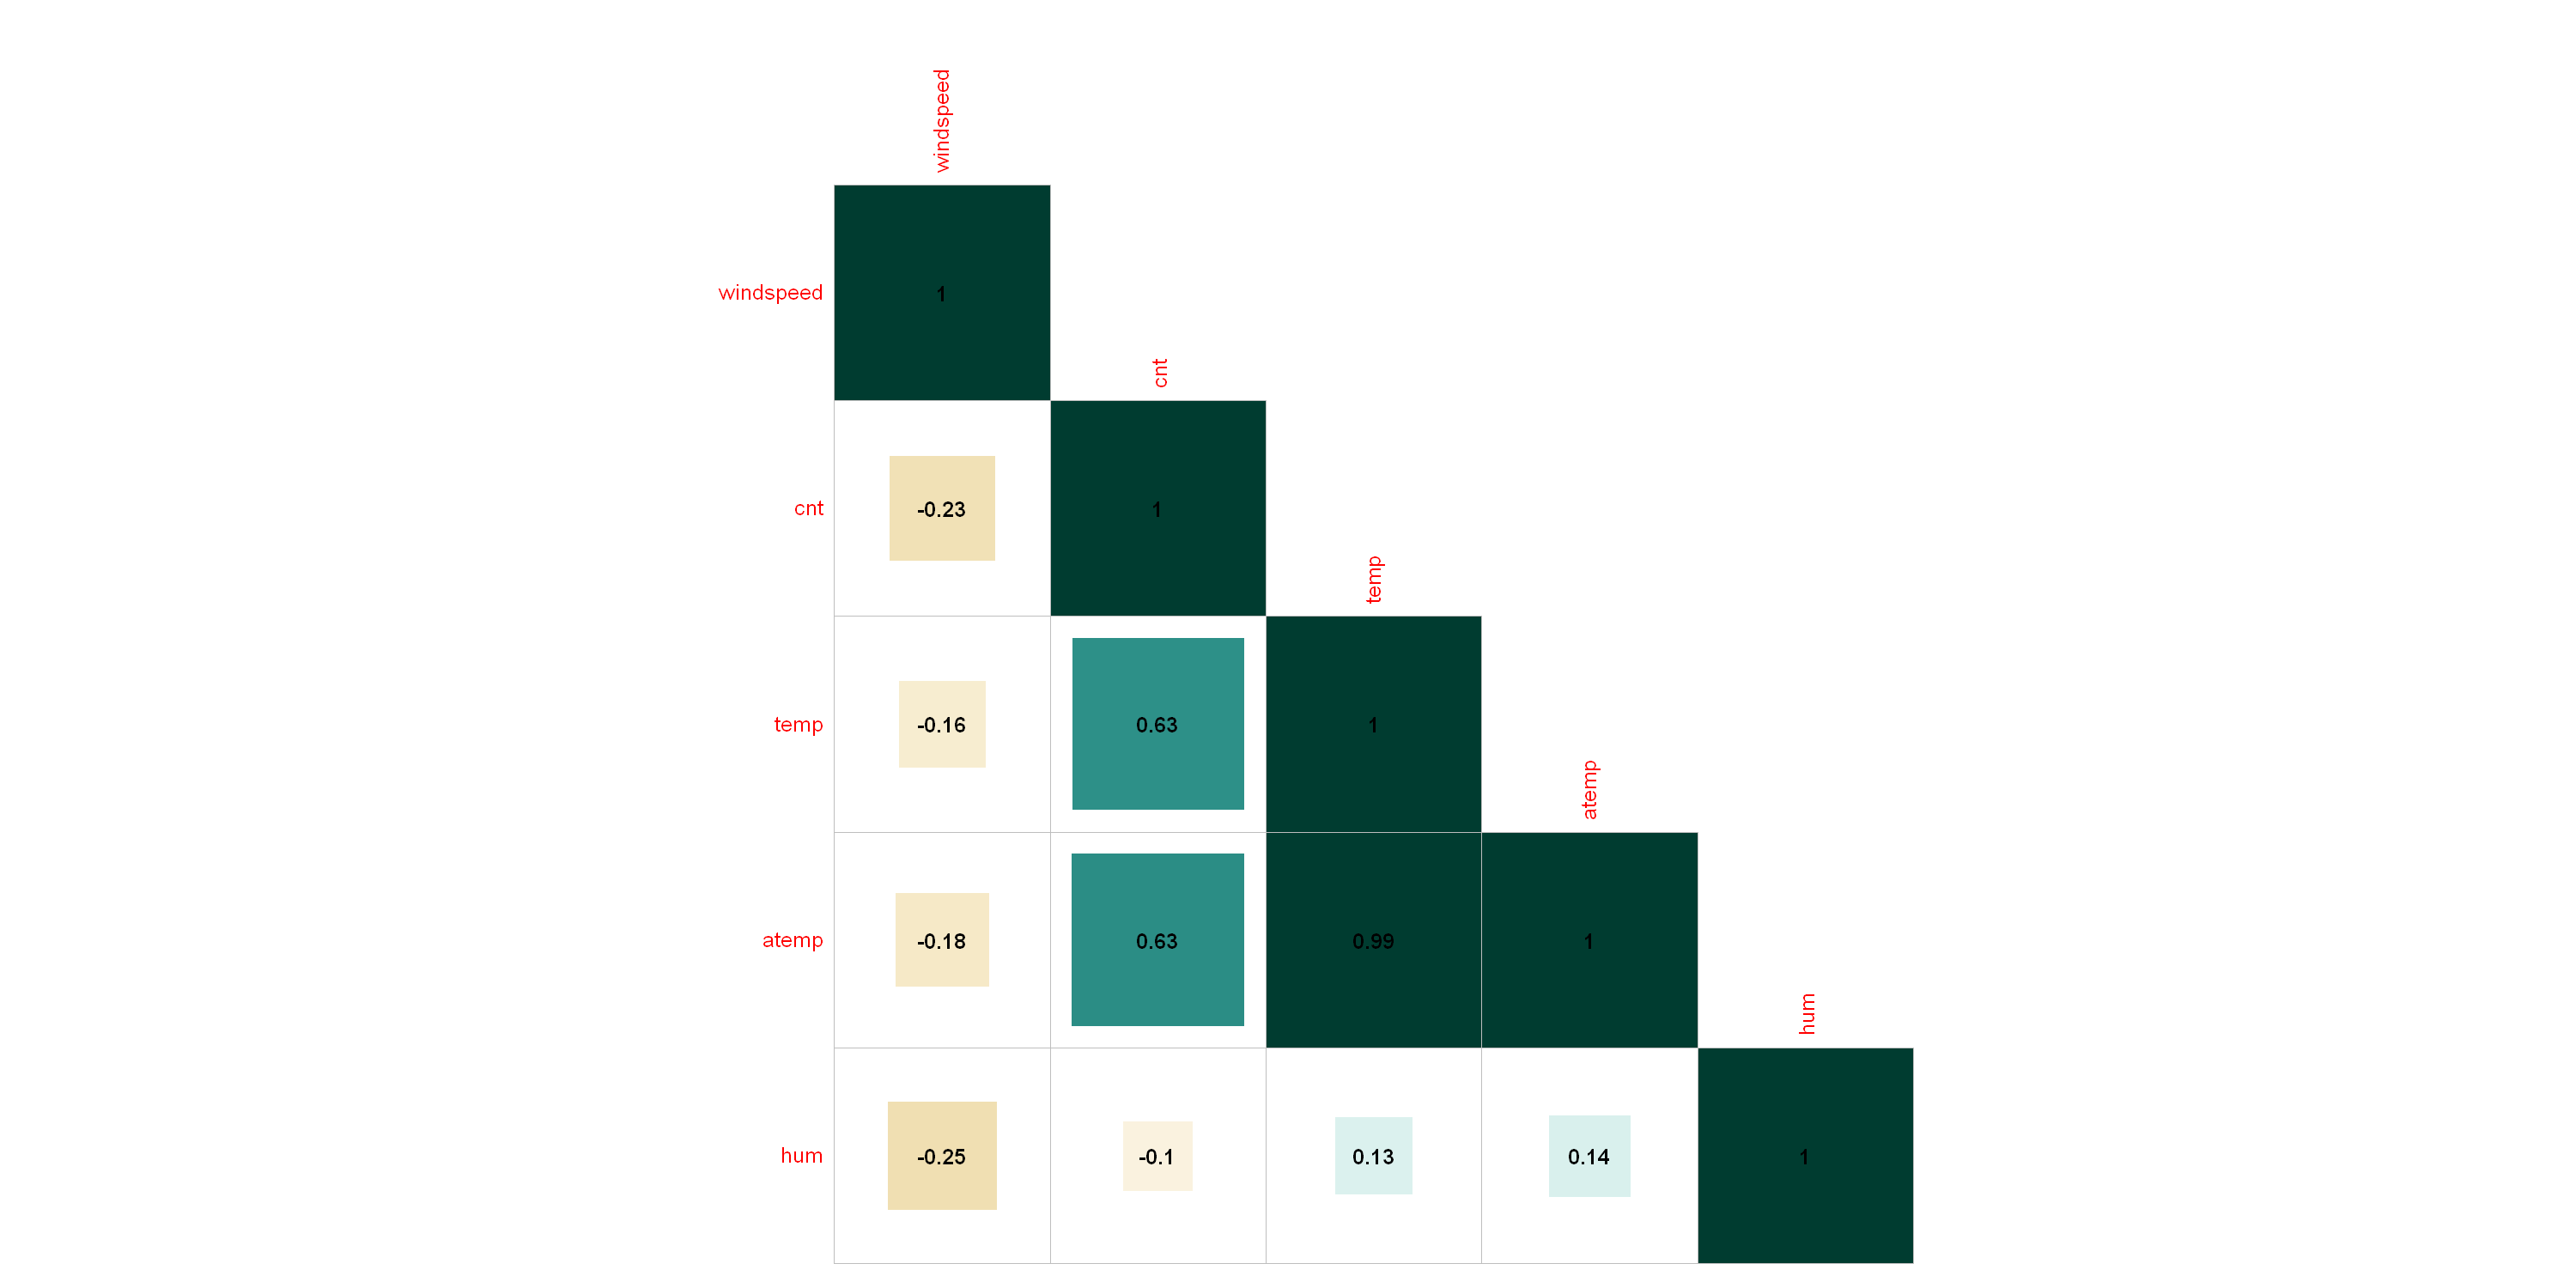

In [338]:
bikes_day %>%
    select_if(~is.numeric(.) || is.logical(.)) %>%
    cor(use = "complete.obs") %>%
    corrplot(method = "square", order = "AOE", addCoef.col = "black", tl.pos = "ld",  cl.pos = "n", col = COL2("BrBG"), type = "lower")

## `atemp` and `temp`
`atemp` ( normalized feeling temperature ) and `temp` ( actual temperature ) are highly correlated (99%) - one can be removed.

In [339]:
bikes_day <- bikes_day %>%
    select(-atemp)

## Scatter matrix

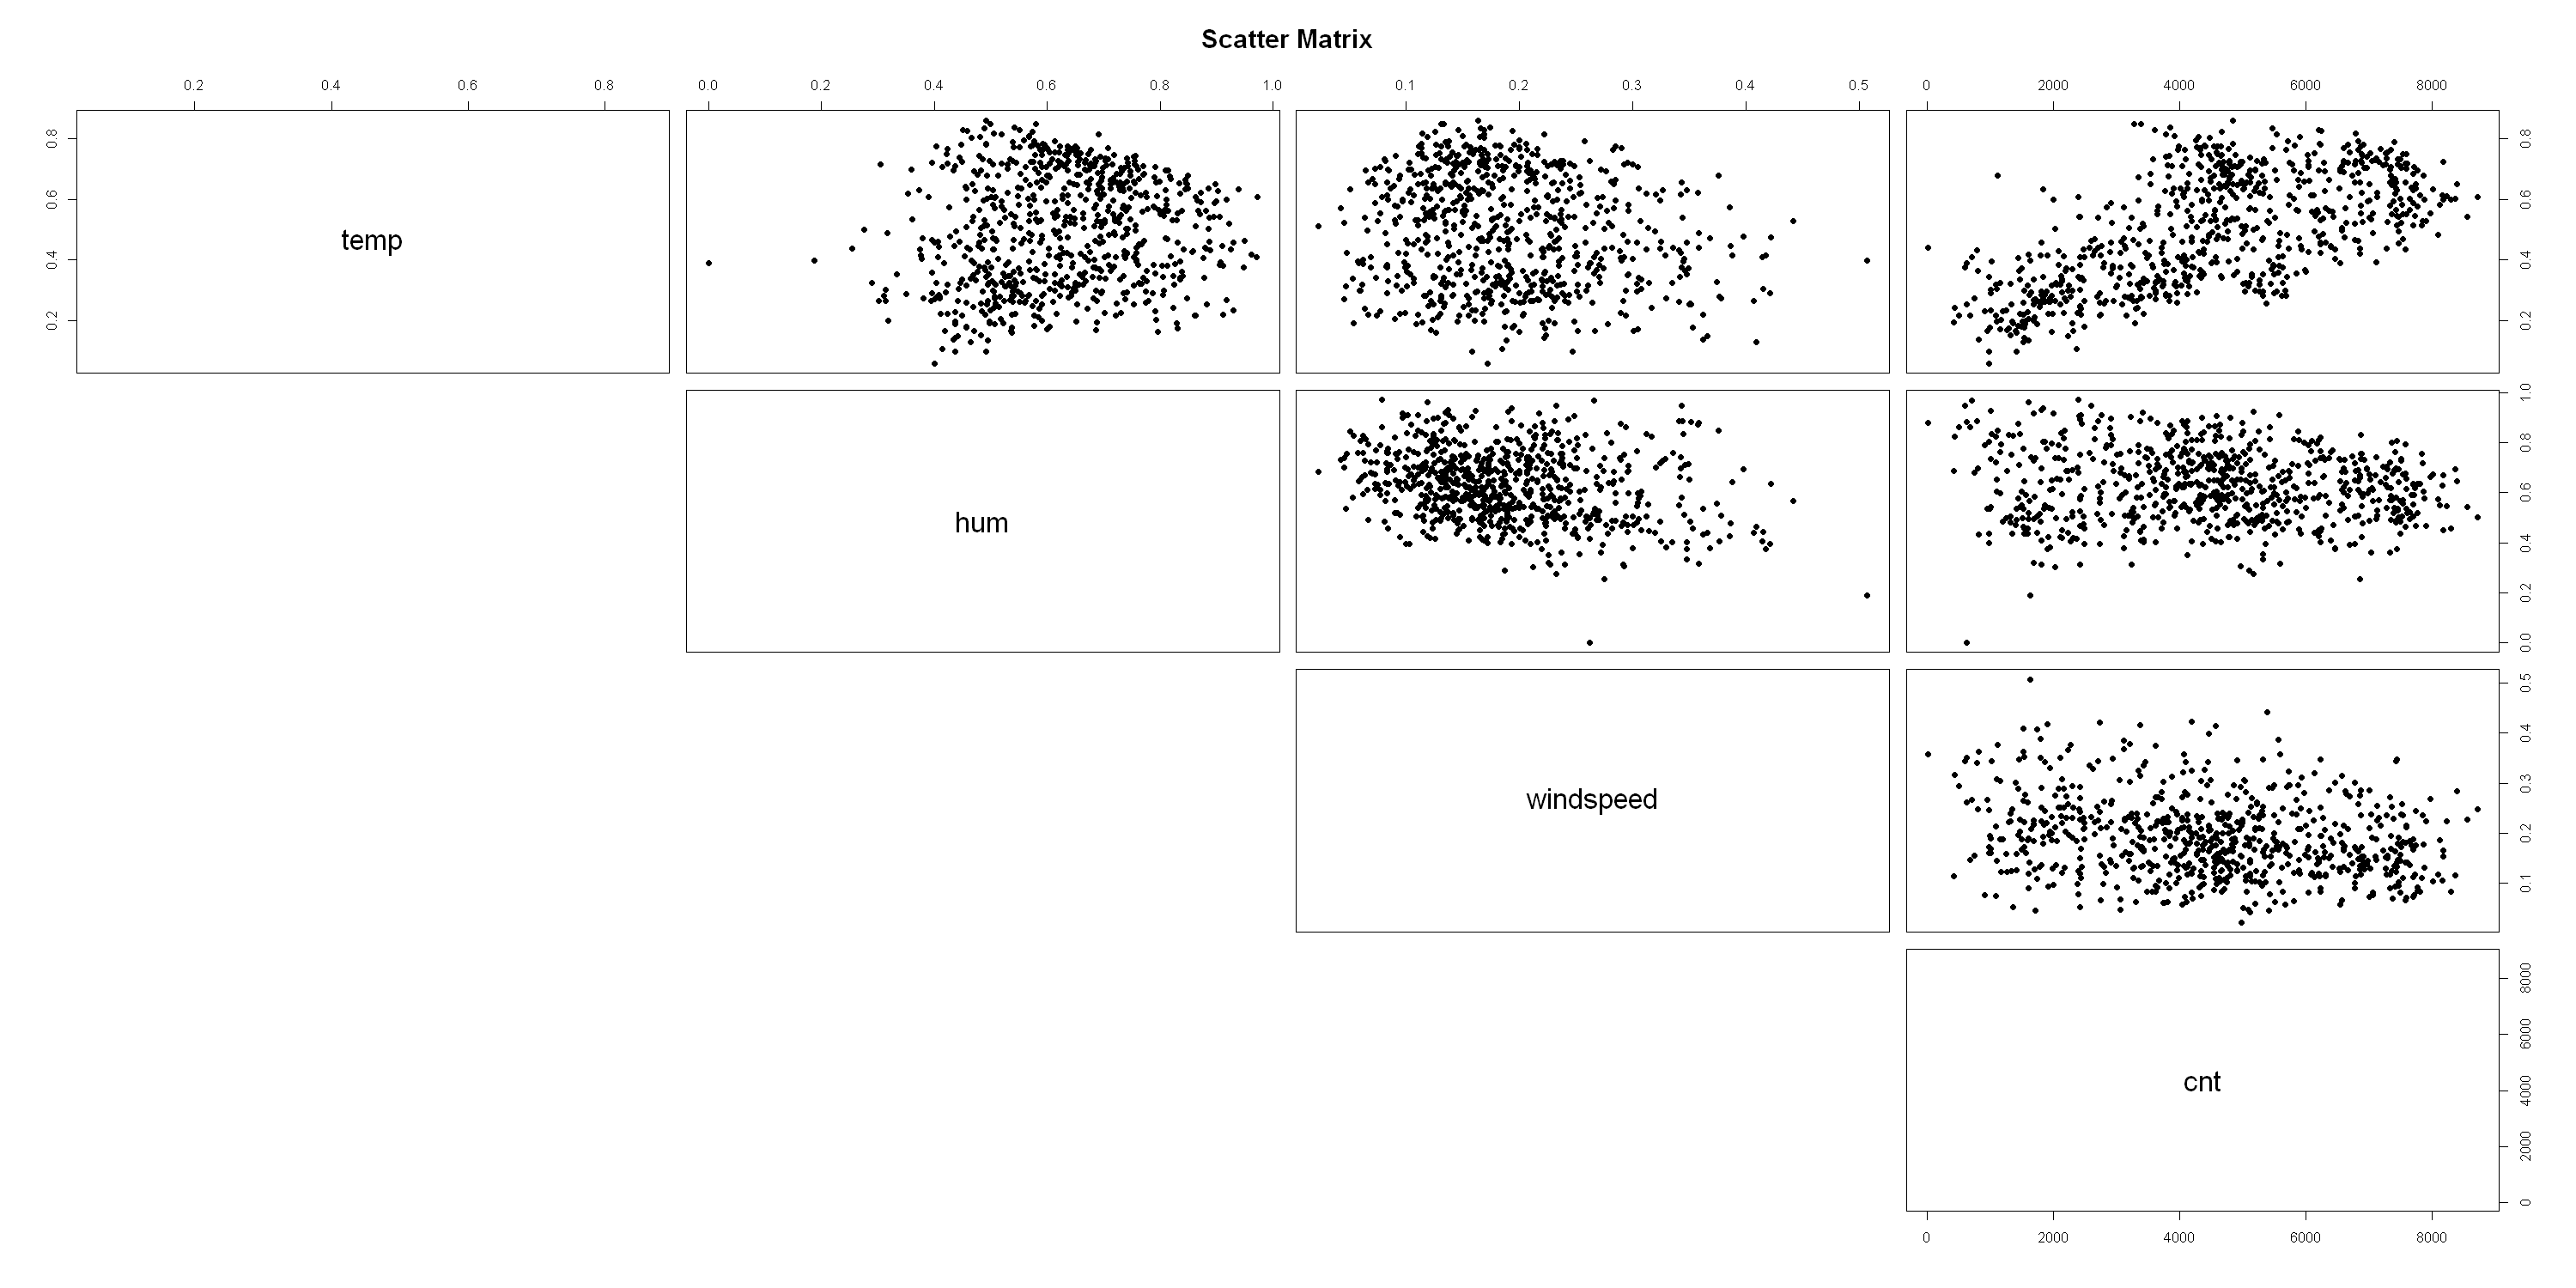

In [340]:
bikes_day %>%
    select_if(~is.numeric(.)) %>%
    pairs(
        pch = 19,
        cex = 1,
        lower.panel = NULL,
        main = "Scatter Matrix"
    )

## Visualize time data

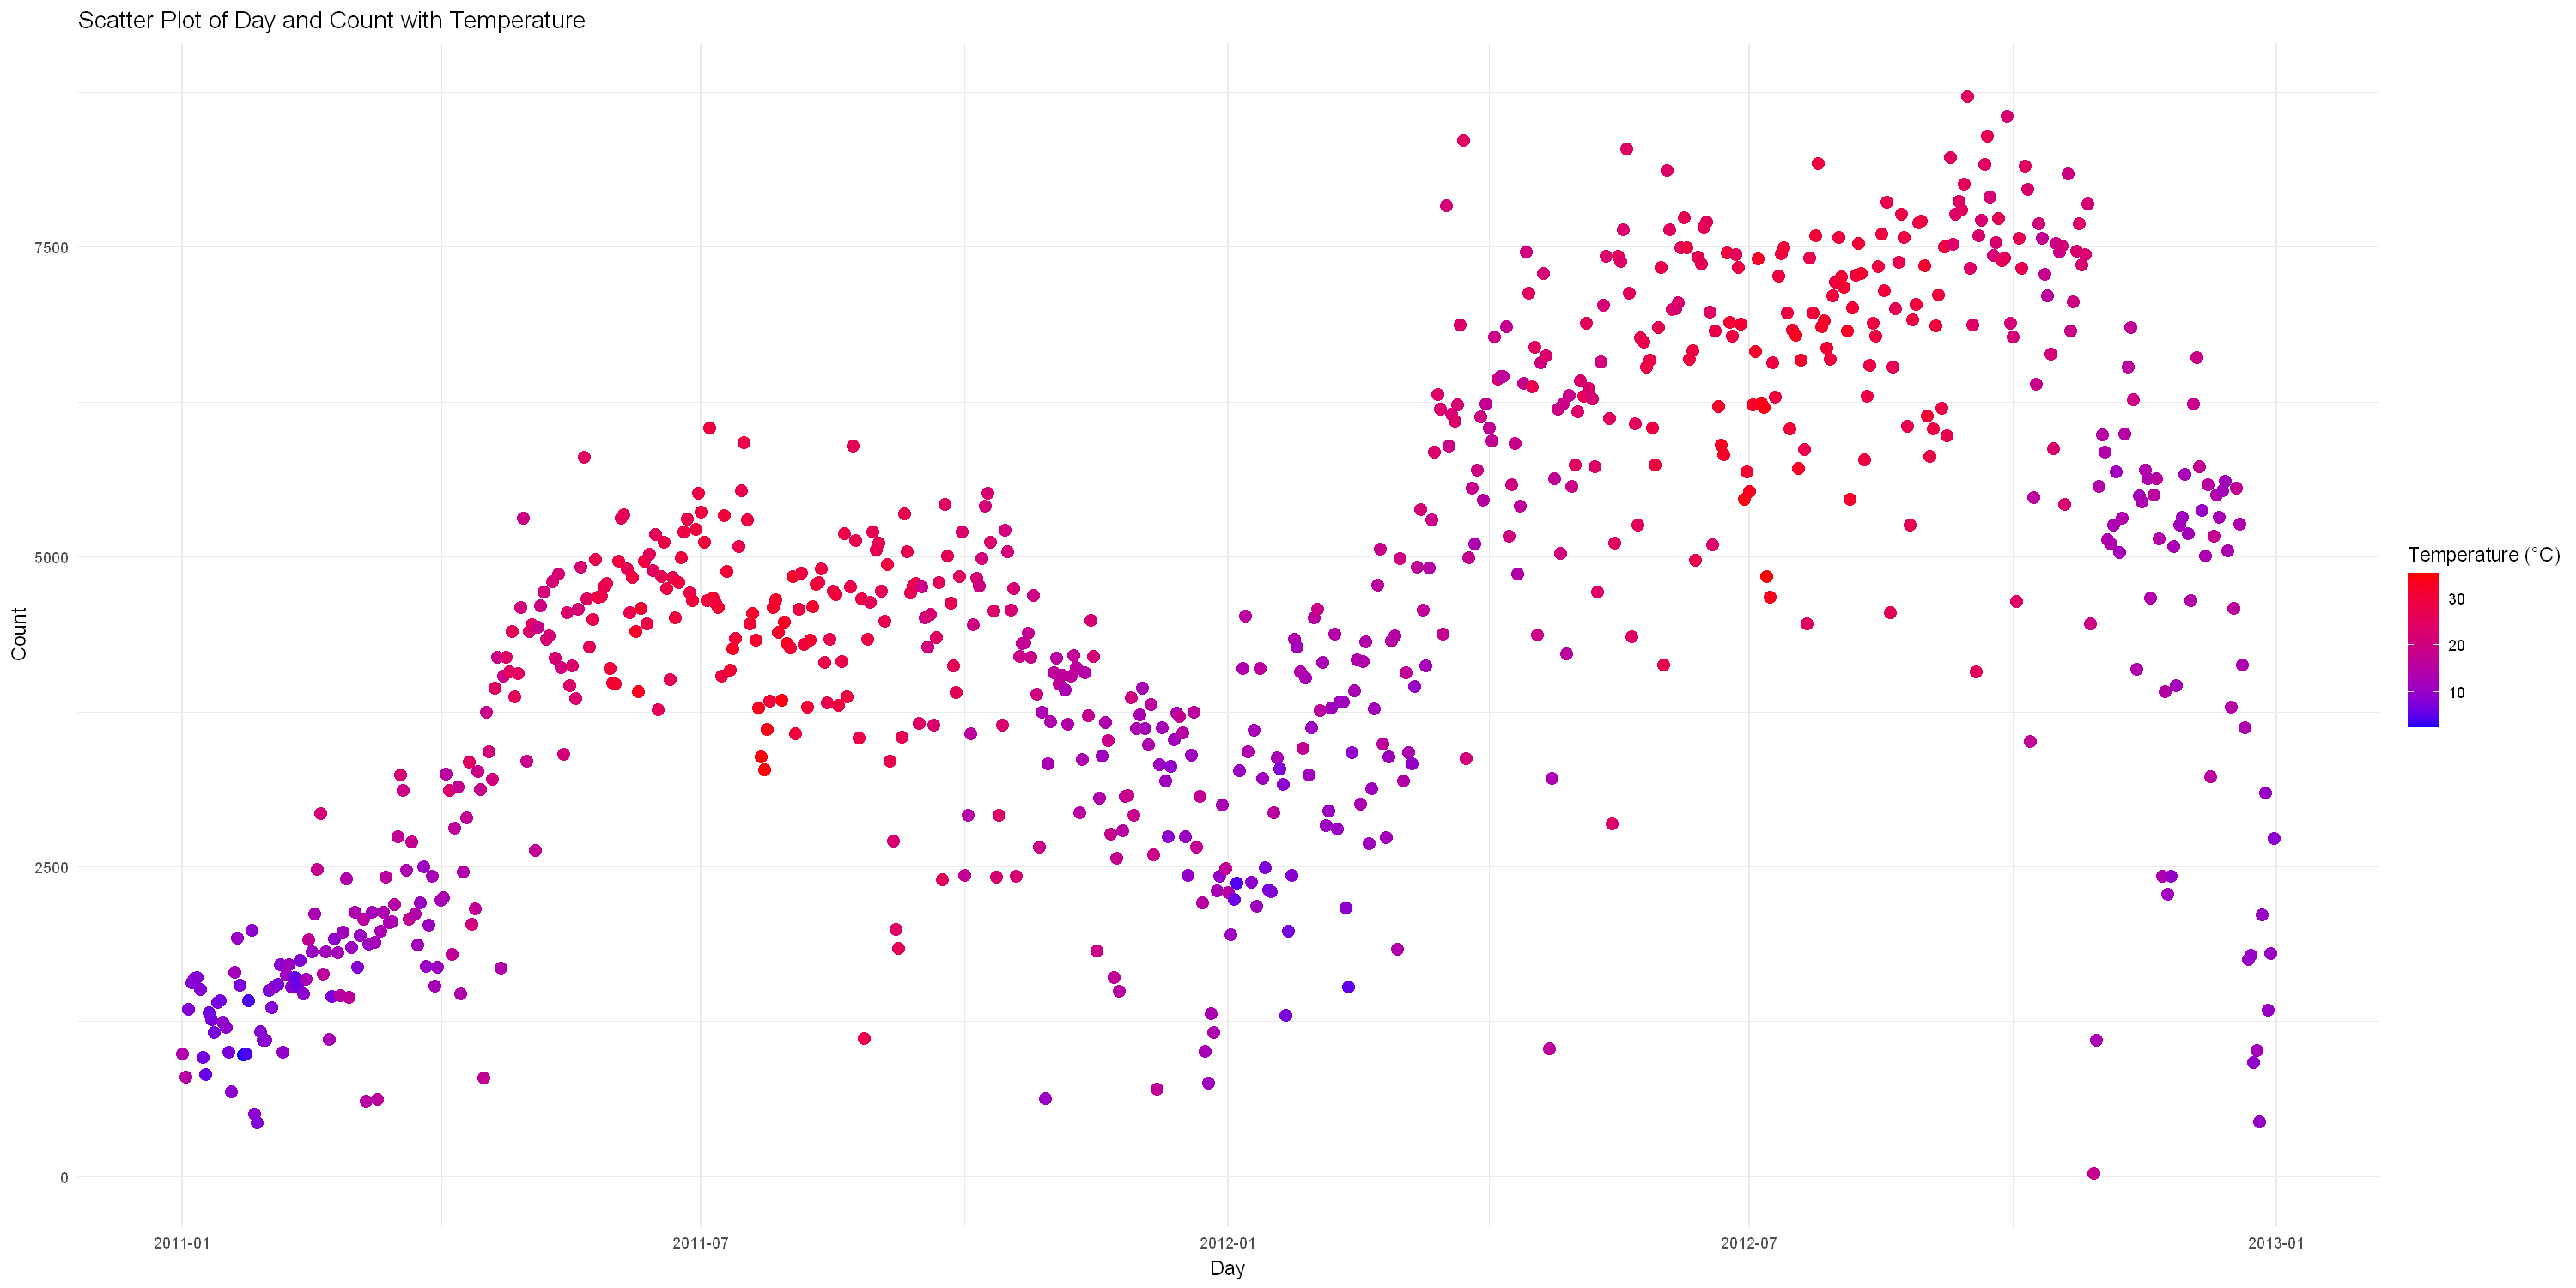

In [341]:
bikes_day %>%
    mutate(temp = temp * 41) %>% # Convert to celcius
    ggplot(aes(x = dteday, y = cnt, color = temp)) +
    geom_point(size = 3) +
    labs(title = "Scatter Plot of Day and Count with Temperature",
        x = "Day",
        y = "Count",
        color = "Temperature (°C)") +
    scale_color_gradient(low = "blue", high = "red") +  # Color gradient from blue to red
    theme_minimal()

The year 2012 has significantly more rentals than the year 2011. The high correlation between the count and temperature is visible on the diagram (highlighted in red).

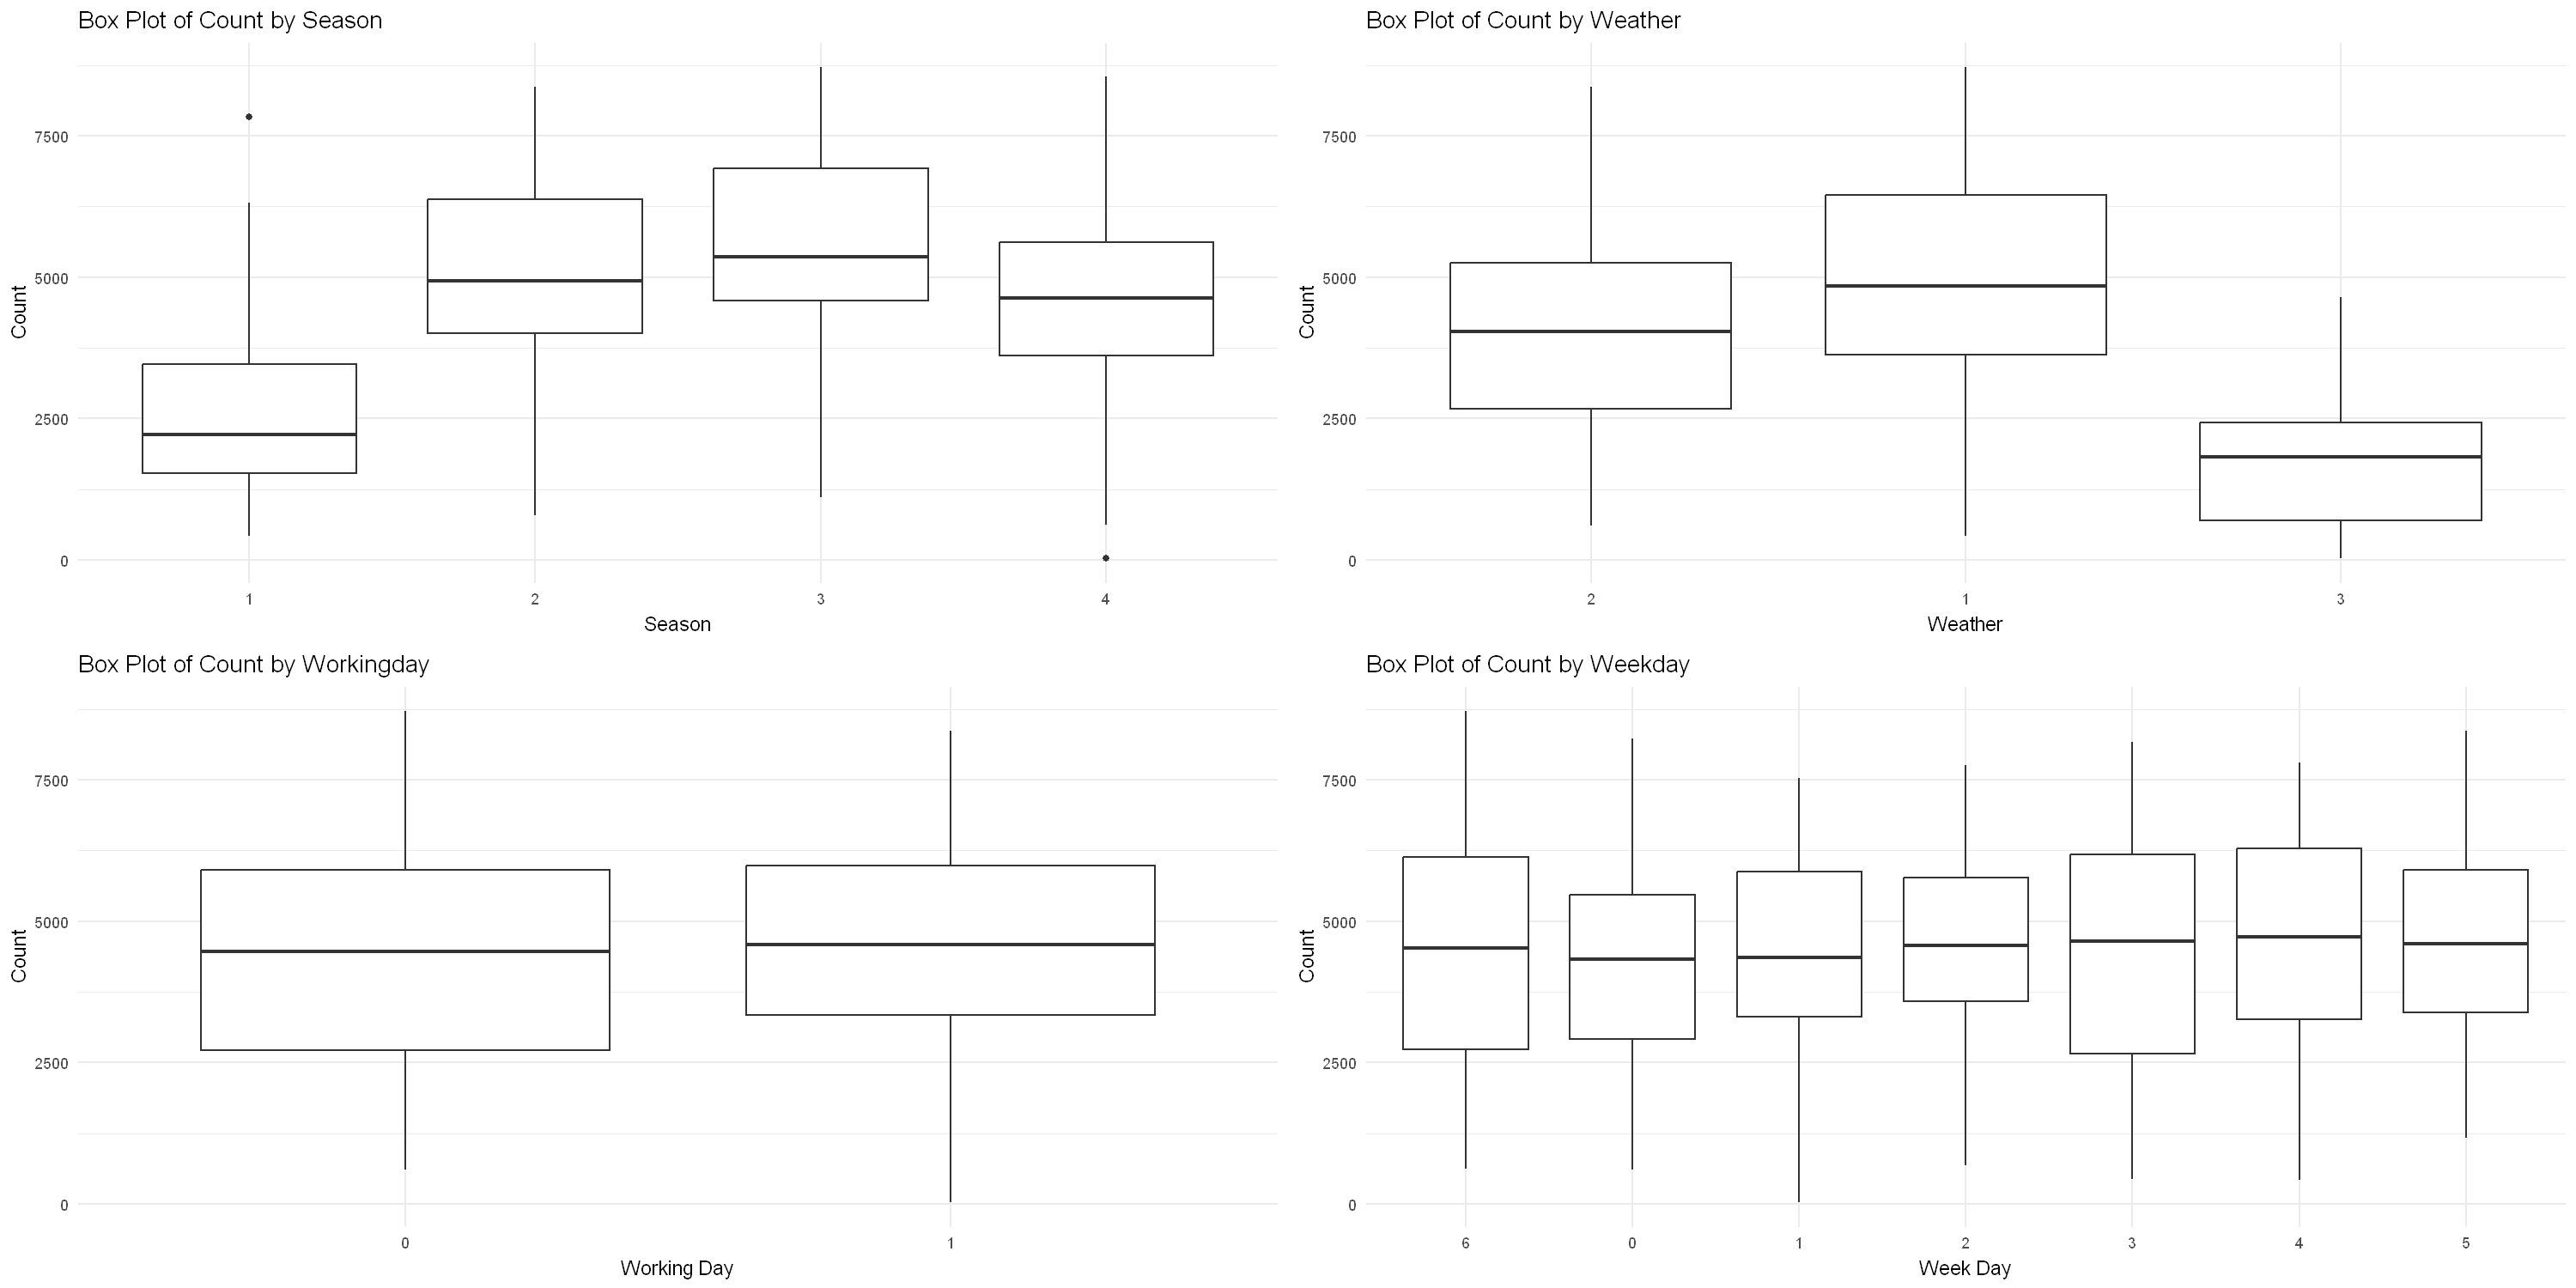

In [342]:
p0 <- bikes_day %>%
    ggplot(aes(x = season, y = cnt)) +
    geom_boxplot() +
    labs(title = "Box Plot of Count by Season",
        x = "Season",
        y = "Count"
    ) +
    theme_minimal()

p1 <- bikes_day %>%
    ggplot(aes(x = weathersit, y = cnt)) +
    geom_boxplot() +
    labs(title = "Box Plot of Count by Weather",
        x = "Weather",
        y = "Count"
    ) +
    theme_minimal()

p2 <- bikes_day %>%
    ggplot(aes(x = workingday, y = cnt)) +
    geom_boxplot() +
    labs(title = "Box Plot of Count by Workingday",
        x = "Working Day",
        y = "Count"
    ) +
    theme_minimal()

p3 <- bikes_day %>%
    ggplot(aes(x = weekday, y = cnt)) +
    geom_boxplot() +
    labs(title = "Box Plot of Count by Weekday",
        x = "Week Day",
        y = "Count"
    ) +
    theme_minimal()

grid.arrange(p0, p1, p2, p3, ncol = 2)

The correlations `cnt`  by `season` and `weather` are visible. The `cnt` variable is not correlated with the working day or week day.

# Model

In [343]:
lin <- lm(cnt ~ yr + season + weathersit + temp + windspeed, data = bikes_day)
summary(lin)


Call:
lm(formula = cnt ~ yr + season + weathersit + temp + windspeed, 
    data = bikes_day)

Residuals:
    Min      1Q  Median      3Q     Max 
-3783.9  -424.2    81.8   508.9  3276.7 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   263.10     151.45   1.737   0.0828 .  
yr1          2049.19      62.72  32.671  < 2e-16 ***
season2      1160.80     116.22   9.988  < 2e-16 ***
season3       894.83     153.16   5.843 7.78e-09 ***
season4      1503.76      98.59  15.252  < 2e-16 ***
weathersit1   629.60      66.96   9.402  < 2e-16 ***
weathersit3 -1652.79     194.70  -8.489  < 2e-16 ***
temp         4856.93     307.56  15.792  < 2e-16 ***
windspeed   -2260.41     419.96  -5.382 9.94e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 842.6 on 722 degrees of freedom
Multiple R-squared:  0.8129,	Adjusted R-squared:  0.8108 
F-statistic: 392.1 on 8 and 722 DF,  p-value: < 2.2e-16


In [344]:
anova_lin <- as.data.frame(Anova(lin)) %>% arrange(desc(`Pr(>F)`))
anova_lin

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
windspeed,20567138,1,28.97044,9.944779e-08
weathersit,146239341,2,102.99482,4.455117e-40
temp,177043129,1,249.37920,1.780888e-48
season,190222232,3,89.31434,3.682405e-49
yr,757787972,1,1067.40410,1.943085e-144
Residuals,512573369,722,NA,NA


In [345]:
anova_lin %>% filter(`Pr(>F)` > 0.05)

Sum Sq,Df,F value,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>


All parameters are significant. The linear model has the adjusted R-squared coefficient equal to 0.8108. 

Parameters : `windspeed`, `weathersit`, `temp`, `season`, `yr`

Predicted: `cnt`

Adjusted R2: 0.8108

# Data : hours.csv

# Get the data

In [346]:
bikes_hour <- read_csv("data/hour.csv",
    col_types = "fDffffffffdddddiii")

head(bikes_hour)

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<fct>,<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1


## Visualize day data

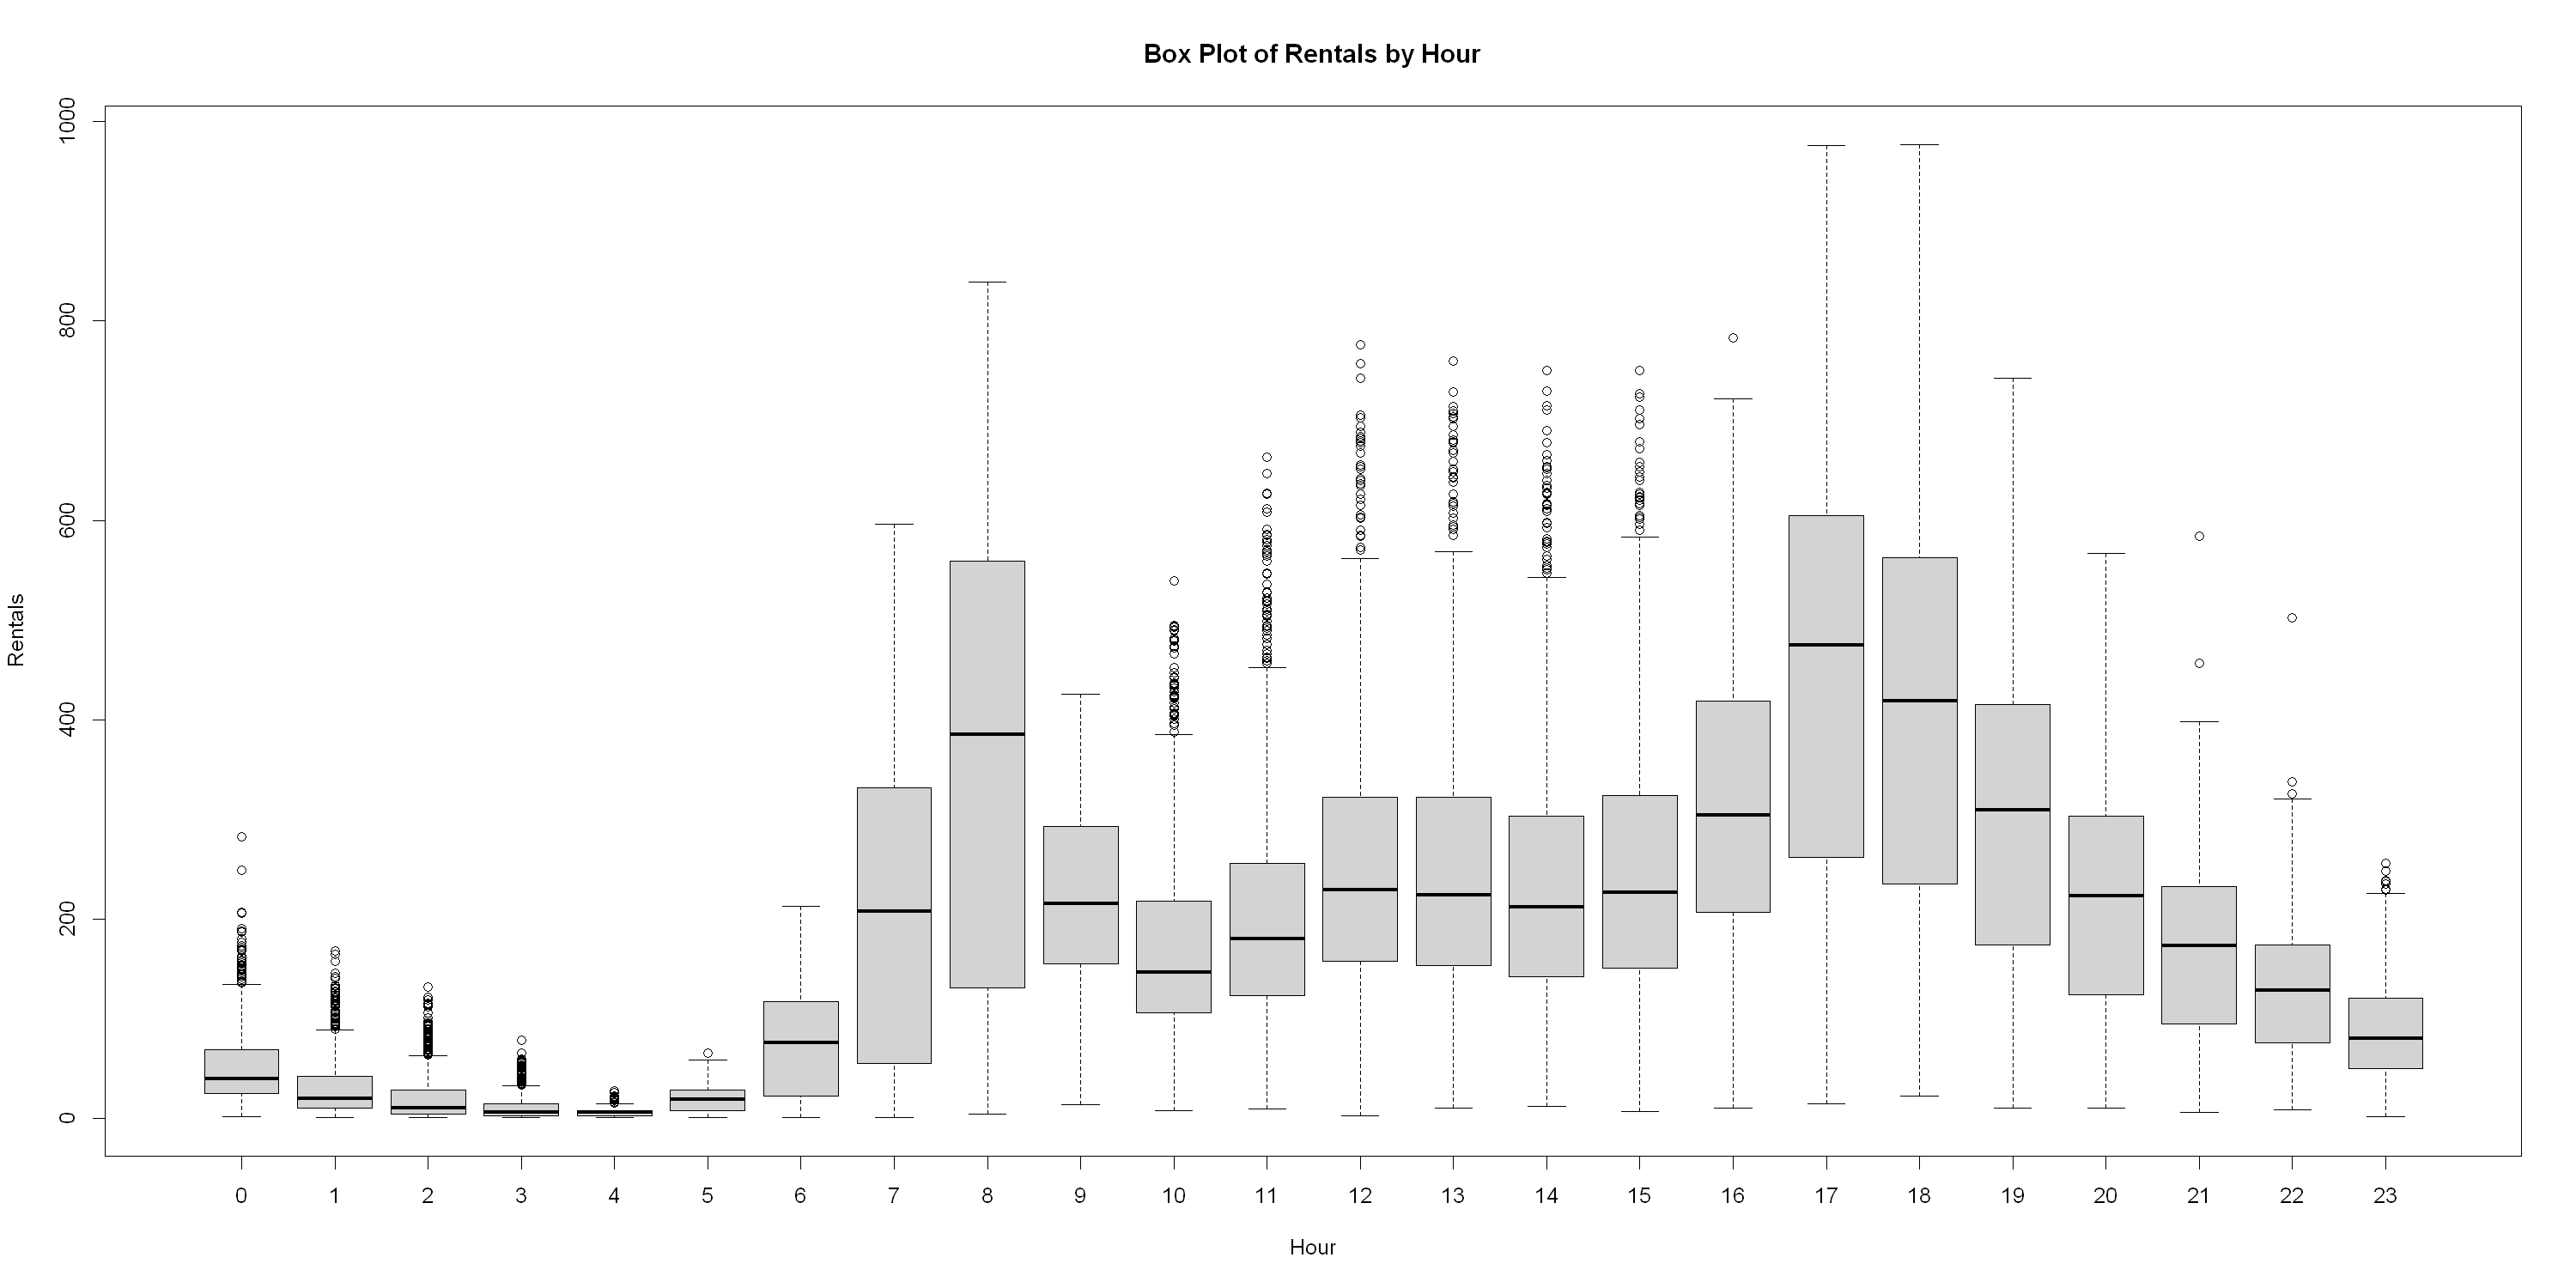

In [347]:
boxplot(bikes_hour$cnt ~ bikes_hour$hr,
	main = "Box Plot of Rentals by Hour",
	xlab = "Hour",
	ylab = "Rentals"
)

Bikes are usually rented during the day hours.

# Model

In [348]:
lin <- lm(cnt ~ yr + season + weathersit + temp + windspeed + hr, data = bikes_hour)
summary(lin)


Call:
lm(formula = cnt ~ yr + season + weathersit + temp + windspeed + 
    hr, data = bikes_hour)

Residuals:
    Min      1Q  Median      3Q     Max 
-413.70  -60.42   -7.09   50.84  475.16 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -122.516      4.772 -25.674  < 2e-16 ***
yr1           87.457      1.571  55.671  < 2e-16 ***
season2       41.001      2.834  14.470  < 2e-16 ***
season3       25.159      3.663   6.868 6.73e-12 ***
season4       61.367      2.430  25.252  < 2e-16 ***
weathersit2  -18.757      1.826 -10.272  < 2e-16 ***
weathersit3  -83.903      2.923 -28.703  < 2e-16 ***
weathersit4  -95.605     59.626  -1.603 0.108861    
temp         243.059      7.143  34.029  < 2e-16 ***
windspeed    -13.645      6.709  -2.034 0.041978 *  
hr1          -18.340      5.419  -3.384 0.000715 ***
hr2          -28.191      5.436  -5.186 2.18e-07 ***
hr3          -39.466      5.473  -7.211 5.77e-13 ***
hr4          -43.781      5.474  -7.998 1.35e-15 

In [349]:
anova_lin <- as.data.frame(Anova(lin)) %>% arrange(desc(`Pr(>F)`))
anova_lin

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
windspeed,44018.3,1,4.136689,4.197836e-02
season,8189473.2,3,256.539539,6.561326e-163
weathersit,9077409.8,3,284.354618,3.373078e-180
temp,12321730.7,1,1157.954021,9.424959e-246
yr,32978827.6,1,3099.237178,0.000000e+00
hr,233426080.2,23,953.764474,0.000000e+00
Residuals,184577917.4,17346,NA,NA


In [350]:
anova_lin %>% filter(`Pr(>F)` > 0.05)

Sum Sq,Df,F value,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>


All parameters are significant. This model created with the additional parameter `hr` has performed significantly worse than the model crafted with the `day` data. 

Parameters : `windspeed`, `weathersit`, `temp`, `season`, `yr`, `hr`

Predicted: `cnt`

Adjusted R2: 0.6766

Its adjusted R-squared coefficient is only 0.6766 compared to the previously achieved 0.8108.